In [339]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [340]:
# Crop out the leading and trailing white space from all sides (left, right, top, bottom)
def crop_white_space(image):
    # Find non-white rows
    non_white_rows = np.where(image.min(axis=1) < 255)[0]
    top = non_white_rows.min()  
    bottom = non_white_rows.max()
    
    # Find non-white columns
    non_white_cols = np.where(image.min(axis=0) < 255)[0]
    left = non_white_cols.min()
    right = non_white_cols.max()
    
    # Crop the image to include only the relevant part of the barcode
    cropped_image = image[top:bottom+1, left:right+1]
    
    return cropped_image


def read_barcode(image):
    # Crop out the leading and trailing white space 
    cropped = crop_white_space(image)
    _, binary = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Get the average of each column in your image
    mean = binary.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Find the first black pixel in the image
    i = 0 
    for pixel in pixels:
        if pixel != "1":
            i += 1
        else:
            break
    i = (i * (-1)) 

    # Shift the image to the left by i pixels to align the barcode with the left edge of the image
    if i != 0:
        rows, cols = cropped.shape[:2]
        translation_matrix = np.float32([[1, 0, (i)], [0, 1, 0]])  
        cropped = cv2.warpAffine(cropped, translation_matrix, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(0))
        _, binary = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = binary.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))
    
    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break
    
    # Set a tolerance value for determining if a bar is narrow or wide
    tolerance = 1
    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except IndexError:
            pass  
        pixel_index += 1
        
        
        if count <= narrow_bar_size + tolerance:
            current_digit_widths += NARROW
        else:
            current_digit_widths += WIDE


        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True

        if pixel_index >= len(pixels):
            break

    print(digits)


In [341]:
def remove_finger(image):
    # Detect the finger (skin color) and mask it out
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8) 
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Create an inverted mask where skin is white (255) and non-skin is black (0)
    binary_skin_mask = skin_mask
    
    # Create a blank white image
    white_image = np.ones_like(image) * 255
    
    # Replace skin regions with white in the original image
    masked_image = cv2.bitwise_and(white_image, white_image, mask=binary_skin_mask)  # White for skin
    background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary_skin_mask))  # Original for non-skin
    result = cv2.add(background, masked_image)

    # Convert to grayscale
    gray_image = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    return gray_image

In [342]:
def preprocess_barcode(image):
    wave_noise = False
    
    # Remove the finger region from the image
    finger_free_image = remove_finger(image)
    
    # Preprocess the image to enhance the barcode region
    denoised = cv2.medianBlur(cv2.blur(finger_free_image, (1, 9)), 3)

    # Binarize the image
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Detect periodic noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    dilated = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel)

    # If the dilated image has more than one unique value, then periodic noise is present
    if len(np.unique(dilated)) != 1:
        print ("Periodic noise detected")
        wave_noise = True
        adaptive_image = cv2.adaptiveThreshold(
            finger_free_image, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 
            11,  
            2    
        )
        denoised = cv2.medianBlur(cv2.blur(adaptive_image, (1, 9)), 3)
        _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
    
    # Detect edges using the Sobel filter
    sobelx = cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = cv2.convertScaleAbs(sobelx)
    
    # Close gaps in the barcode lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)
    
    # Find contours and crop the barcode region
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get rotated bounding box
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)

        # Ensure width is always greater than height
        width = int(max(rect[1]))
        height = int(min(rect[1]))

        # Check if the barcode is oriented by checking if the top and bottom sides are parallel 
        isOriented = False
        if box[0, 1] != box[1,1] or box[2,1] != box[3,1]:
            isOriented = True  
                
        # Correct perspective based on the box points
        src_pts = box.astype("float32")
        dst_pts = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype="float32")
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        cropped = cv2.warpPerspective(binary, M, (width, height))

        
        if wave_noise:
            cropped = cv2.medianBlur(cv2.blur(cropped, (1, 50)), 3)
        else:
            cropped = cv2.medianBlur(cv2.blur(cropped, (1, 300)), 3)

        if wave_noise or not isOriented:
            horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 1))
            cropped = cv2.morphologyEx(cropped, cv2.MORPH_CLOSE, horizontal_kernel)
            _, cropped = cv2.threshold(cropped, 195, 255, cv2.THRESH_BINARY)
            
    else:
        cropped = binary
        
    
    return binary, closed, cropped

In [343]:
def visualize_barcode_processing(image, binary, closed, cropped):

    plt.figure(figsize=(20, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    # Binarized Image
    plt.subplot(1, 4, 2)
    plt.imshow(binary, cmap='gray')
    plt.title("Binarized Image")
    plt.axis("off")

    # Closed Image (After Morphological Processing)
    plt.subplot(1, 4, 3)
    plt.imshow(closed, cmap='gray')
    plt.title("Closed Image")
    plt.axis("off")

    # Cropped Barcode
    plt.subplot(1, 4, 4)
    plt.imshow(cropped, cmap='gray')
    plt.title("Cropped Barcode")
    plt.axis("off")

    plt.show()

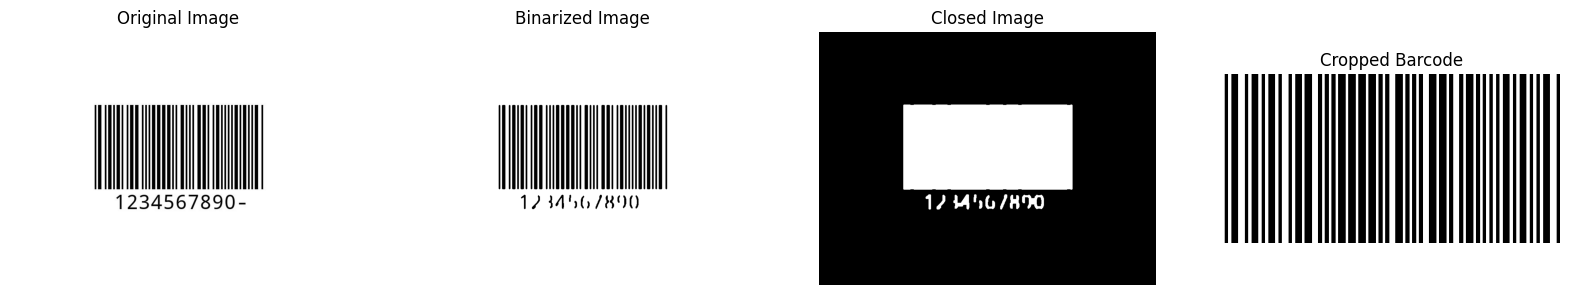

['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']


In [344]:
image_path = "Test Cases\\01 - lol easy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

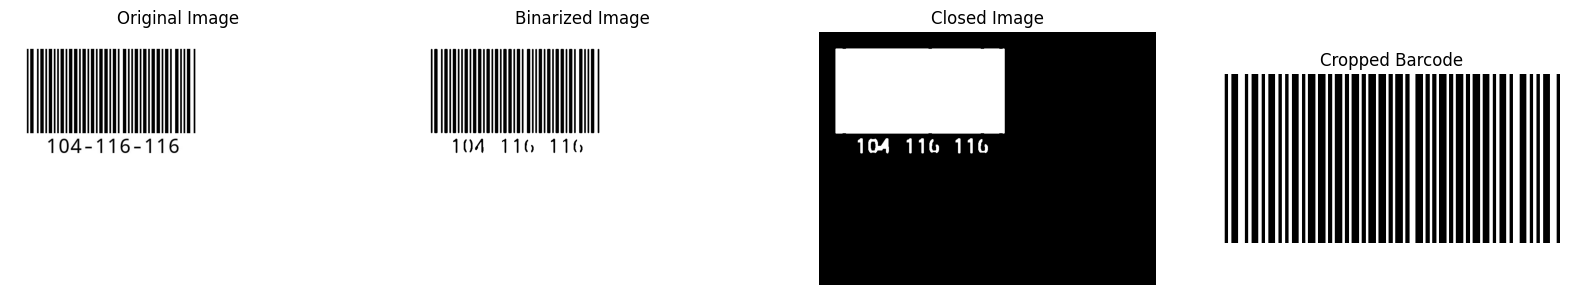

['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']


In [345]:
image_path = "Test Cases\\02 - still easy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

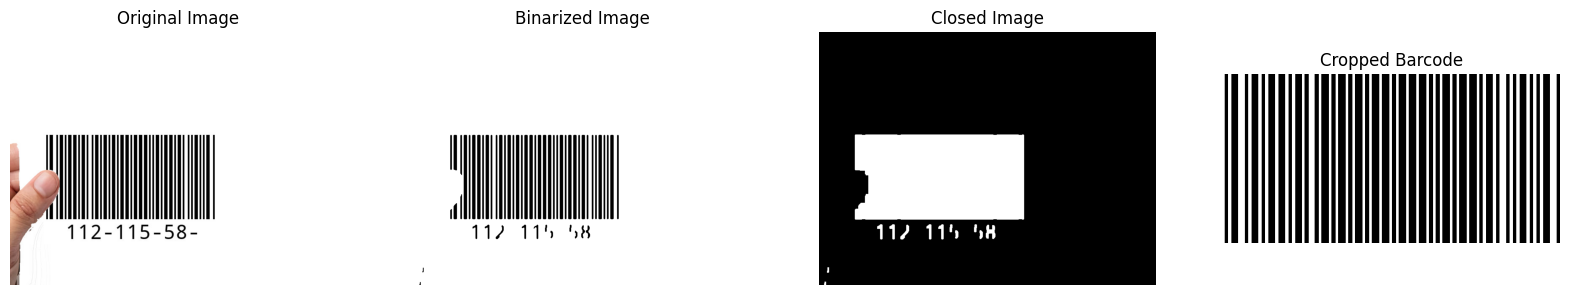

['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']


In [346]:
image_path = "Test Cases\\03 - eda ya3am ew3a soba3ak mathazarsh.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

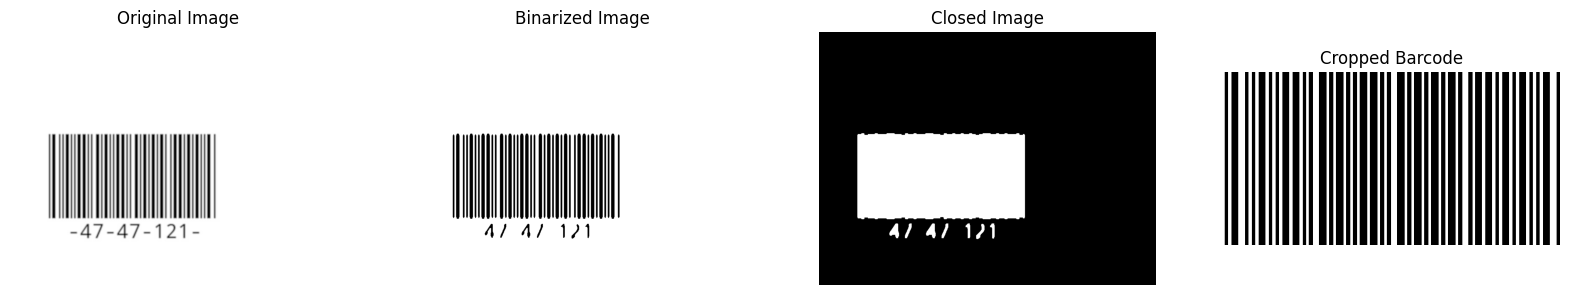

['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']


In [347]:
image_path = "Test Cases\\04 - fen el nadara.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

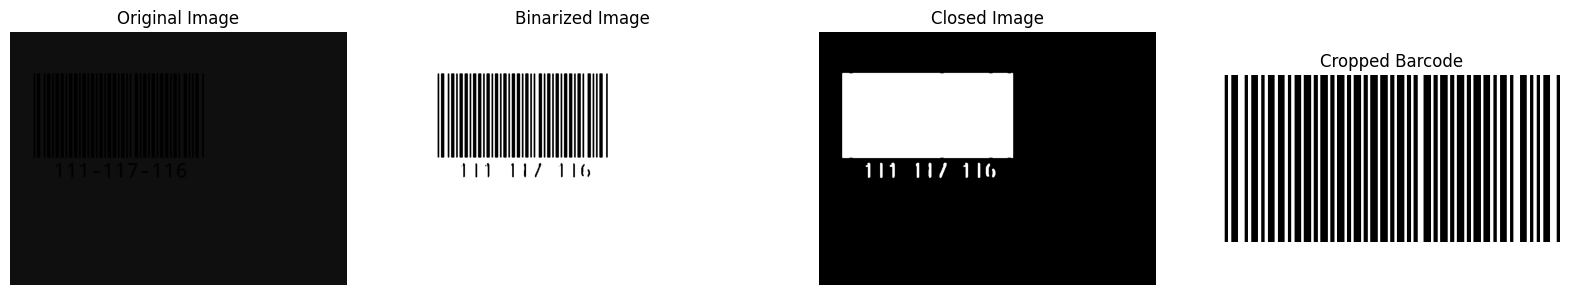

['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']


In [348]:
image_path = "Test Cases\\05 - meen taffa el nour!!!.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

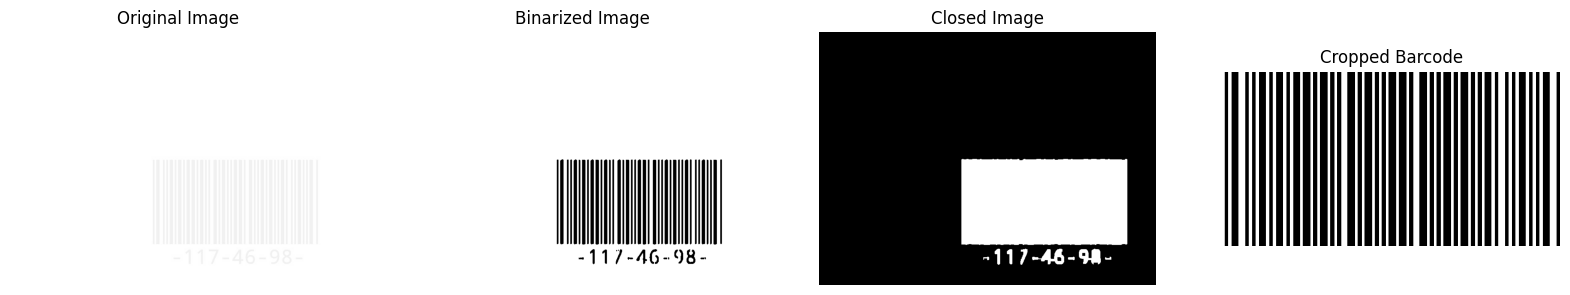

['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']


In [349]:
image_path = "Test Cases\\06 - meen fata7 el nour 333eenaaayy.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

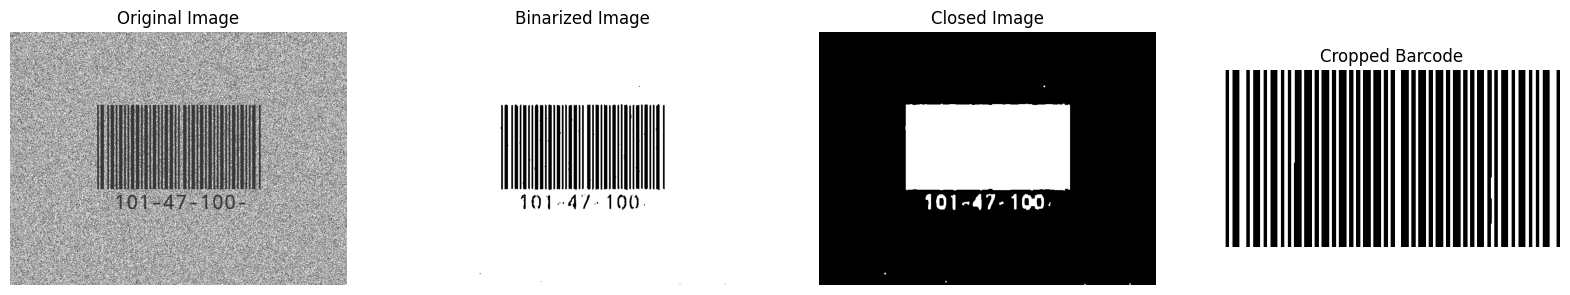

['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']


In [350]:
image_path = "Test Cases\\07 - mal7 w felfel.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

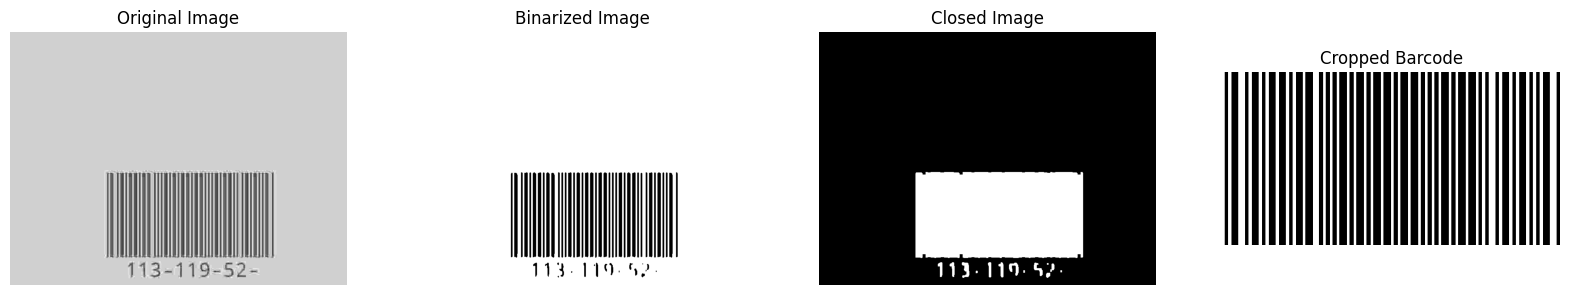

['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']


In [351]:
image_path = "Test Cases\\08 - compresso espresso.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

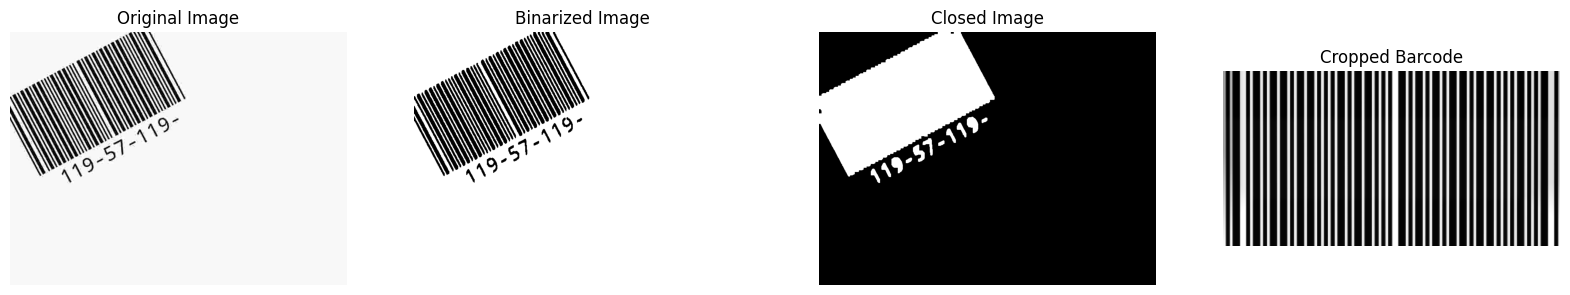

['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']


In [352]:
image_path = "Test Cases\\09 - e3del el soora ya3ammm.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

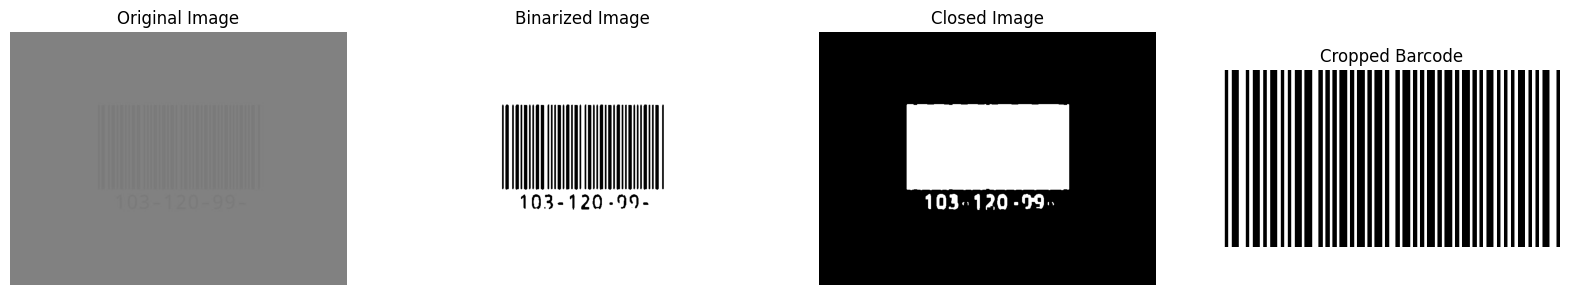

['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']


In [353]:
image_path = "Test Cases\\10 - wen el kontraastttt.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)

Periodic noise detected


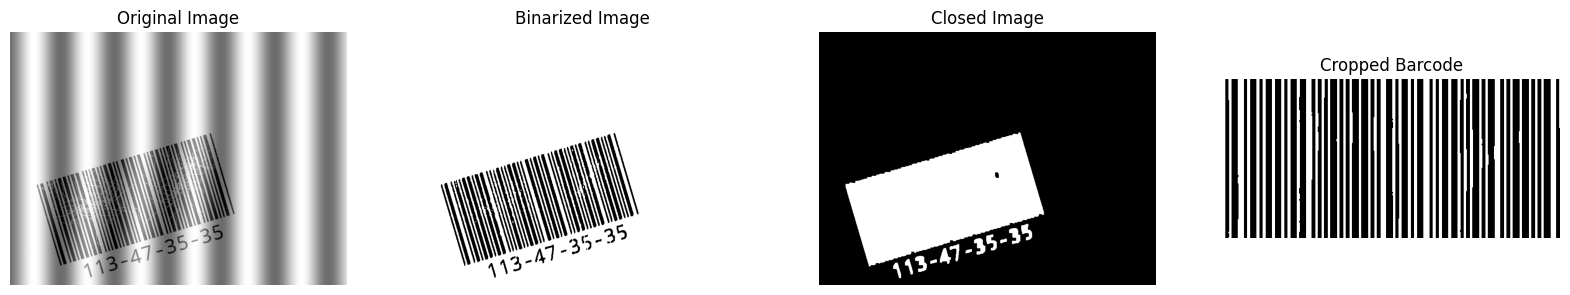

['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']


In [354]:
image_path = "Test Cases\\11 - bayza 5ales di bsara7a.jpg"  
image = cv2.imread(image_path)

# Preprocess the barcode
binary, closed, cropped = preprocess_barcode(image)

# Visualize the barcode processing steps
visualize_barcode_processing(image, binary, closed, cropped)

read_barcode(cropped)